Загрузить необходимые данные к себе и считать (read) их в переменную.

<Axes: >

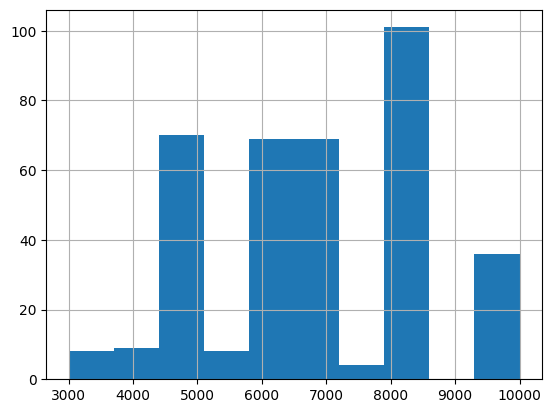

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


data = pd.read_csv("./Sleep_health_and_lifestyle_dataset.csv")
data["Daily Steps"].hist()

Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии (если у вас многоклассовая классификация, прочтите P.S.S. внизу).

Так как я буду исследовать зависимость болезни сна от нескольких параметров, а болезни у меня могут быть (апноэ, бессоница, здоровый), то у меня будет многоклассовая классификация.

Сделать предобработку данных:
1 Разделить выборку на тренировочную (train) и тестовую (test). Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test.
2 Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
3 Отнормировать численные переменные (StandardScaler, MinMaxScaler).
4 Закодировать категориальные признаки по одной из стратегий.


In [ ]:
data = data.drop(columns=['Blood Pressure']) # удалил все строковые значения, тк у нас слишком маленькая выборка для того чтоб на них ориентироваться, а вариаций много 
data['Sleep Disorder'] = data['Sleep Disorder'].fillna('Healthy')# заменяем пропуски на здорового человека
data['Sleep Disorder'] = data['Sleep Disorder'].replace({"Healthy": 0, "Sleep Apnea": 1, "Insomnia": 2})

In [87]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Sleep Disorder'])
y = data['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # разделение данных на train и test

In [95]:
print("Проверка на пропуски в тренировочной выборке:")
print(X_train.isnull().sum())



y_test.head(20)

Проверка на пропуски в тренировочной выборке:
Age                        0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
Heart Rate                 0
Daily Steps                0
dtype: int64


329    0.0
33     0.0
15     0.0
325    0.0
57     0.0
239    2.0
76     0.0
119    0.0
332    0.0
126    0.0
233    2.0
39     0.0
153    0.0
55     0.0
155    0.0
278    2.0
0      0.0
231    2.0
336    0.0
101    0.0
Name: Sleep Disorder, dtype: float64

У нас нет больше нулевых значений, следовательно заполнять их не надо. Проведём стандартизацию

In [118]:
from sklearn.discriminant_analysis import StandardScaler
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])

X_train_final = pd.DataFrame(X_train_scaled, columns=num_features)
X_test_final = pd.DataFrame(X_test_scaled, columns=num_features)
X_test_all = X_test_final + X_train_final
print("Тренировочная выборка:", X_train_final.shape)
print("Тестовой выборка:", X_test_final.shape)
X_test_all.head()
print(X_train_final.head())
print(X_test_final.head())

Тренировочная выборка: (299, 7)
Тестовой выборка: (75, 7)
        Age  Sleep Duration  Quality of Sleep  Physical Activity Level   
0  0.055811       -0.833457         -1.155098                -0.728644  \
1 -1.111141       -1.468533         -1.155098                -1.450369   
2 -0.877751        0.436694          0.537913                -0.006920   
3  1.922934        1.325801          1.384419                 0.714805   
4 -1.577922       -0.833457         -2.001604                -0.969219   

   Stress Level  Heart Rate  Daily Steps  
0      0.956601    0.481081    -0.554643  
1      1.522984    0.481081    -1.180447  
2     -0.176166   -0.014076     0.696966  
3     -1.308933   -0.509234     0.071162  
4      0.956601    2.461710    -1.806251  
        Age  Sleep Duration  Quality of Sleep  Physical Activity Level   
0  1.222763        1.706846          1.384419                -1.450369  \
1 -1.344532       -1.341518         -1.155098                -1.450369   
2 -1.577922      

Сделаем сразу KNeighborsClassifier, и приведём к нему все метрики. 

Accuracy на тестовых значениях: 0.8933
ROC-AUC (One-vs-Rest) на тестовых значениях: 0.9319


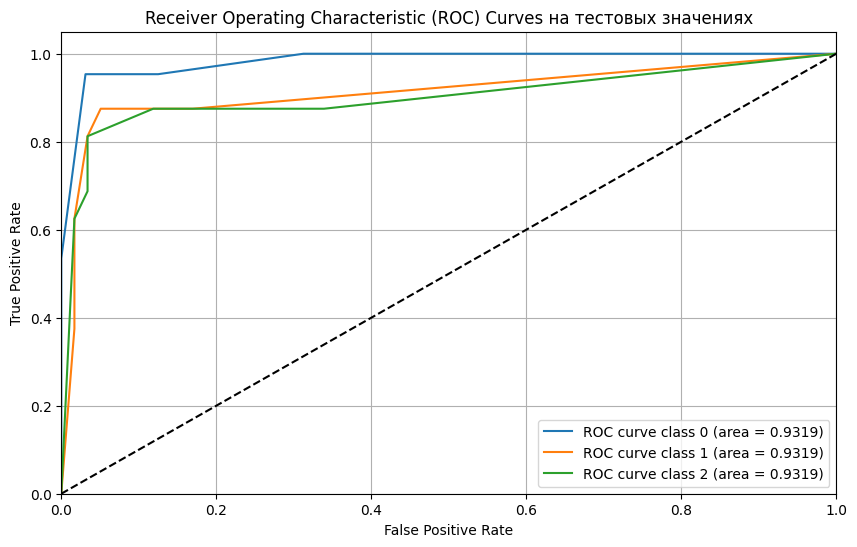

F1 Score (weighted)  на тестовых значениях: 0.8937


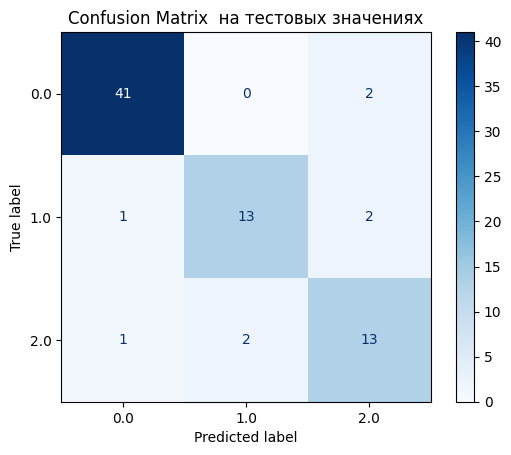

Accuracy на тренировочных значениях: 0.8863
ROC-AUC (One-vs-Rest) на тренировочных значениях: 0.9733


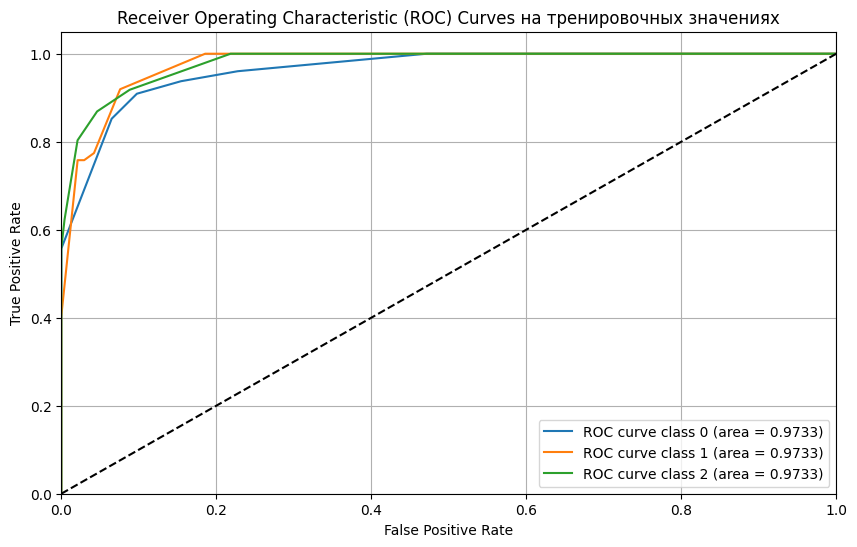

F1 Score (weighted) на тренировочных значениях: 0.8851


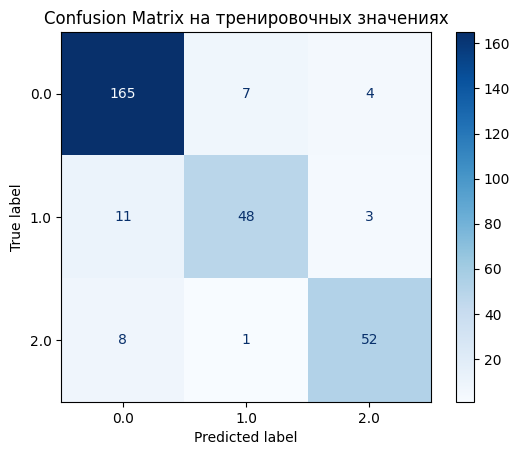

In [139]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

y_pred_test = knn.predict(X_test)
y_pred_proba_test = knn.predict_proba(X_test)

y_pred_train = knn.predict(X_train)
y_pred_proba_train = knn.predict_proba(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy на тестовых значениях: {accuracy_test:.4f}')

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc_test = roc_auc_score(y_test_bin, y_pred_proba_test, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тестовых значениях: {roc_auc_test:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_test:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тестовых значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_test = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1 Score (weighted)  на тестовых значениях: {f1_test:.4f}')

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix  на тестовых значениях')
plt.show()

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy на тренировочных значениях: {accuracy_train:.4f}')

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
roc_auc_train = roc_auc_score(y_train_bin, y_pred_proba_train, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тренировочных значениях: {roc_auc_train:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba_train[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_train:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тренировочных значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_train = f1_score(y_train, y_pred_train, average='weighted')
print(f'F1 Score (weighted) на тренировочных значениях: {f1_train:.4f}')

ConfusionMatrixDisplay.from_estimator(knn, X_train, y_train, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тренировочных значениях')
plt.show()


У нас вышла точность около 89.3% на тестовых и 88.6 на тренировочных. Улучшить метрики можно посредством более объемного датасета. Также, максимальная точность была достигнута при 6 соседях. 

Далее рассмотрим Дерево.

Accuracy на тестовых значениях: 0.8800
ROC-AUC (One-vs-Rest) на тестовых значениях: 0.8481


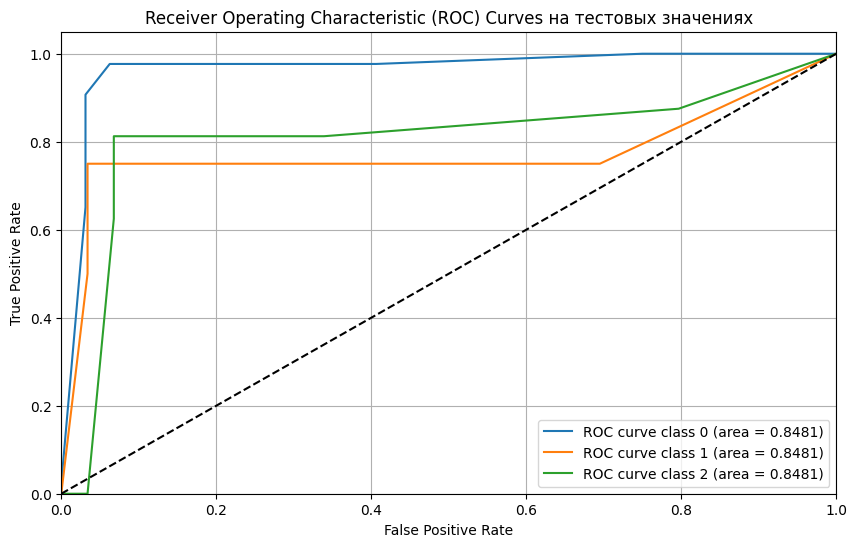

F1 Score (weighted) на тестовых значениях: 0.8785


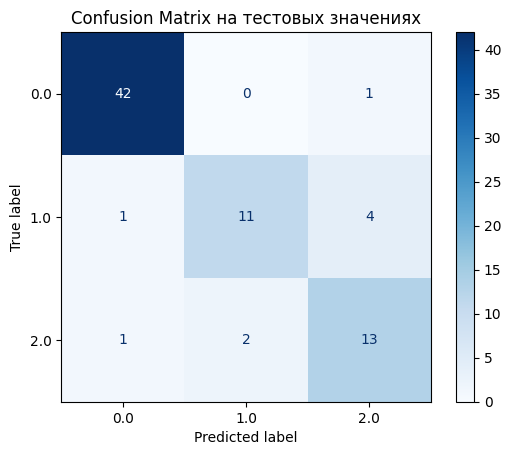

Accuracy на тренировочных значениях: 0.9264
ROC-AUC (One-vs-Rest) на тренировочных значениях: 0.9660


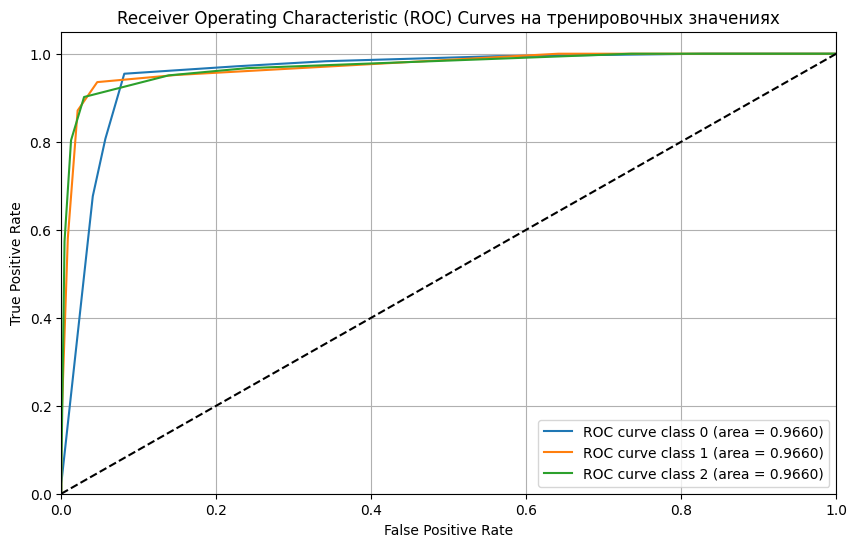

F1 Score (weighted) на тренировочных значениях: 0.9262


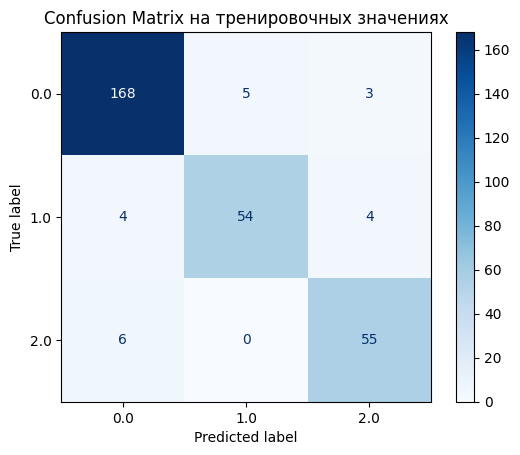

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)

y_pred_test = tree.predict(X_test)
y_pred_proba_test = tree.predict_proba(X_test)

y_pred_train = tree.predict(X_train)
y_pred_proba_train = tree.predict_proba(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy на тестовых значениях: {accuracy_test:.4f}')

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc_test = roc_auc_score(y_test_bin, y_pred_proba_test, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тестовых значениях: {roc_auc_test:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_test:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тестовых значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_test = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1 Score (weighted) на тестовых значениях: {f1_test:.4f}')

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тестовых значениях')
plt.show()

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy на тренировочных значениях: {accuracy_train:.4f}')

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
roc_auc_train = roc_auc_score(y_train_bin, y_pred_proba_train, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тренировочных значениях: {roc_auc_train:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba_train[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_train:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тренировочных значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_train = f1_score(y_train, y_pred_train, average='weighted')
print(f'F1 Score (weighted) на тренировочных значениях: {f1_train:.4f}')

ConfusionMatrixDisplay.from_estimator(tree, X_train, y_train, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тренировочных значениях')
plt.show()


Как мы видим, эта модель значительно лучше справилась с поставленной задачей - 88 процентов на тестовом, 93.3 процентов на тренировочном. Глубина начиная с 3 не влияла (до 3 точность была сильно ниже)

Далее рассмотрим RandomForest

Accuracy на тестовых значениях: 0.8800
ROC-AUC (One-vs-Rest) на тестовых значениях: 0.9172


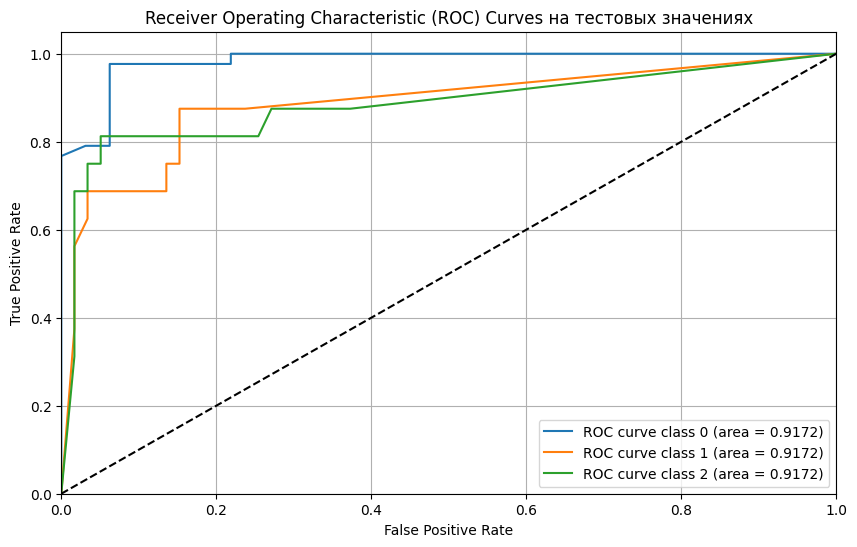

F1 Score (weighted) на тестовых значениях: 0.8763


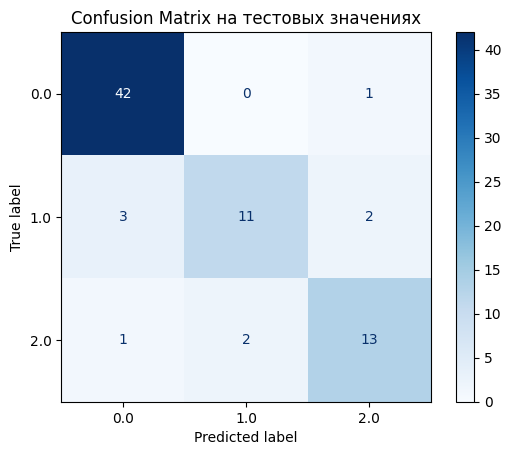

Accuracy на тренировочных значениях: 0.9331
ROC-AUC (One-vs-Rest) на тренировочных значениях: 0.9898


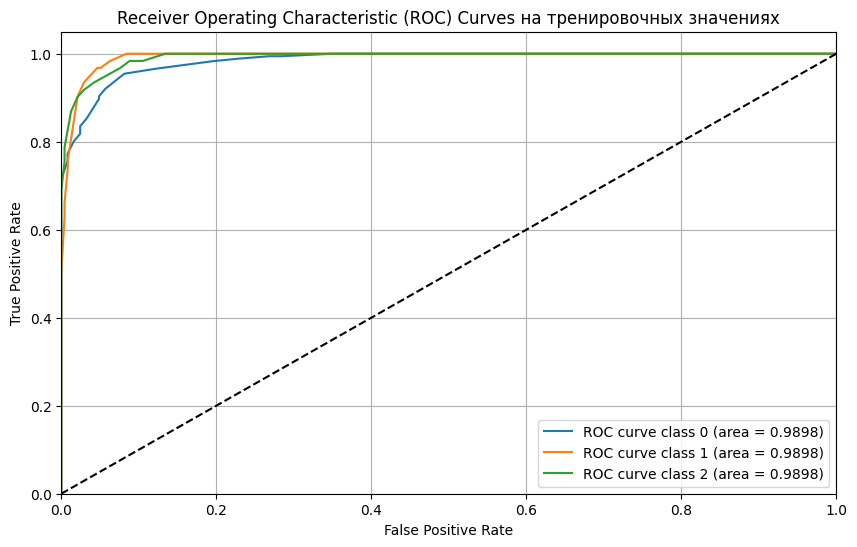

F1 Score (weighted) на тренировочных значениях: 0.9330


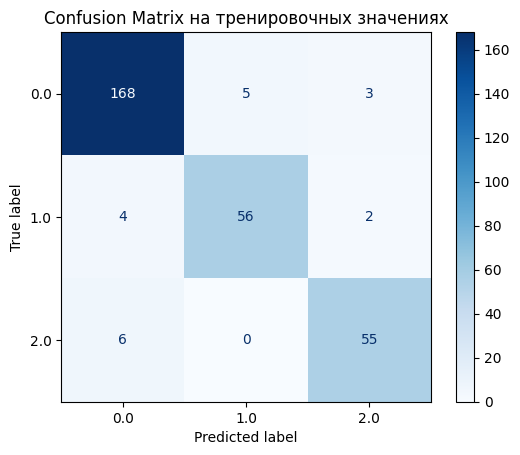

In [126]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred_test = forest.predict(X_test)
y_pred_proba_test = forest.predict_proba(X_test)

y_pred_train = forest.predict(X_train)
y_pred_proba_train = forest.predict_proba(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy на тестовых значениях: {accuracy_test:.4f}')

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc_test = roc_auc_score(y_test_bin, y_pred_proba_test, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тестовых значениях: {roc_auc_test:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_test:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тестовых значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_test = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1 Score (weighted) на тестовых значениях: {f1_test:.4f}')

ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тестовых значениях')
plt.show()

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy на тренировочных значениях: {accuracy_train:.4f}')

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
roc_auc_train = roc_auc_score(y_train_bin, y_pred_proba_train, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тренировочных значениях: {roc_auc_train:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba_train[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_train:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тренировочных значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_train = f1_score(y_train, y_pred_train, average='weighted')
print(f'F1 Score (weighted) на тренировочных значениях: {f1_train:.4f}')

ConfusionMatrixDisplay.from_estimator(forest, X_train, y_train, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тренировочных значениях')
plt.show()

Значения у СлучайногоЛеса оказались идентичные с Деревом. Комментируя как можно улучшить - также дать больше данных для датасета.

Далее расмотрим LogisticRegression

Accuracy на тестовых значениях: 0.6533
ROC-AUC (One-vs-Rest) на тестовых значениях: 0.7783


C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


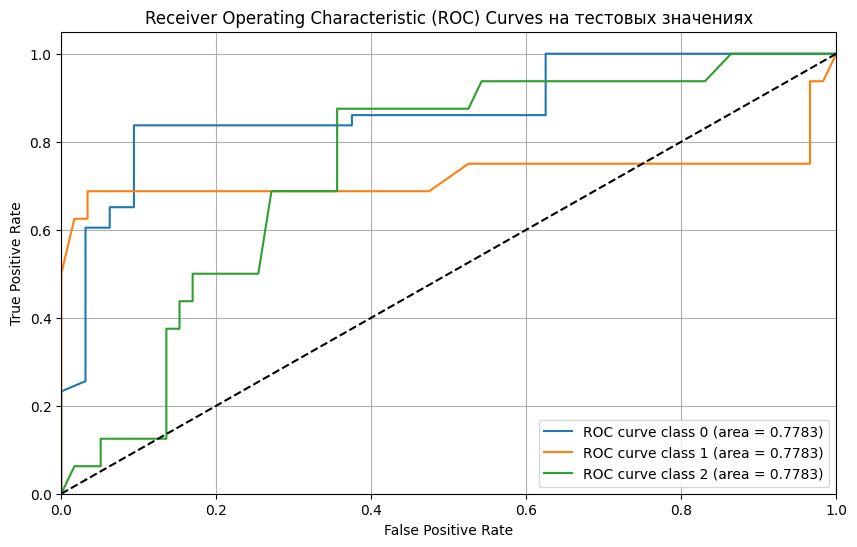

F1 Score (weighted) на тестовых значениях: 0.6251


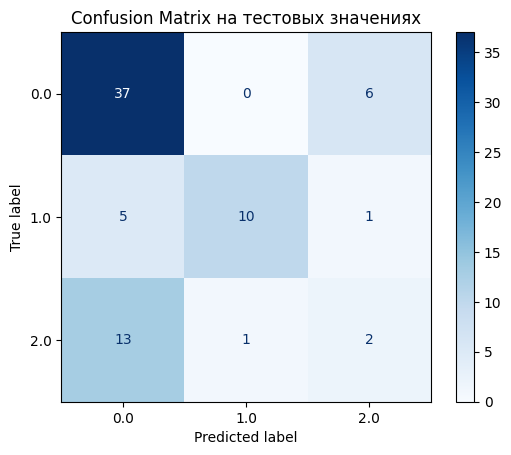

Accuracy на тренировочных значениях: 0.6722
ROC-AUC (One-vs-Rest) на тренировочных значениях: 0.8202


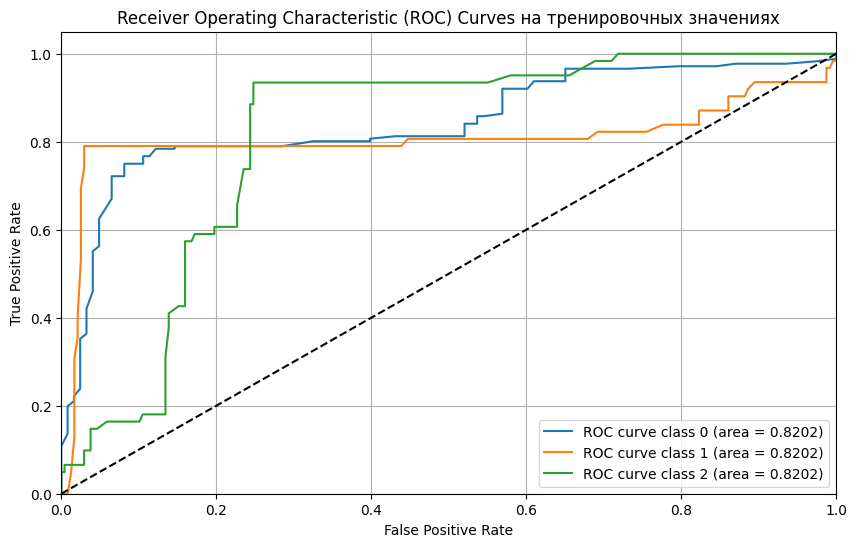

F1 Score (weighted) на тренировочных значениях: 0.6552


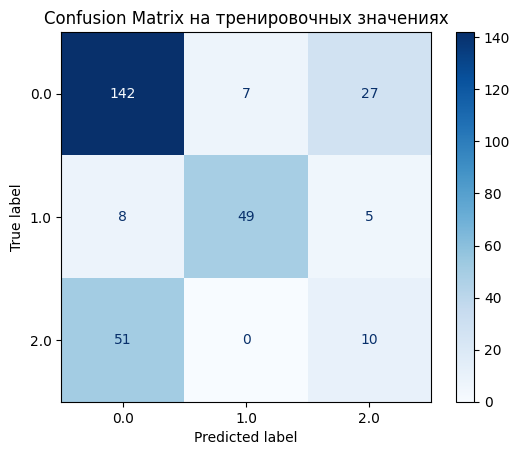

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


Logistic = LogisticRegression()
Logistic.fit(X_train, y_train)

y_pred_test = Logistic.predict(X_test)
y_pred_proba_test = Logistic.predict_proba(X_test)

y_pred_train = Logistic.predict(X_train)
y_pred_proba_train = Logistic.predict_proba(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy на тестовых значениях: {accuracy_test:.4f}')

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc_test = roc_auc_score(y_test_bin, y_pred_proba_test, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тестовых значениях: {roc_auc_test:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_test:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тестовых значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_test = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1 Score (weighted) на тестовых значениях: {f1_test:.4f}')

ConfusionMatrixDisplay.from_estimator(Logistic, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тестовых значениях')
plt.show()

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy на тренировочных значениях: {accuracy_train:.4f}')

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
roc_auc_train = roc_auc_score(y_train_bin, y_pred_proba_train, multi_class='ovr')
print(f'ROC-AUC (One-vs-Rest) на тренировочных значениях: {roc_auc_train:.4f}')

plt.figure(figsize=(10, 6))
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba_train[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve class {i} (area = {roc_auc_train:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves на тренировочных значениях')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_train = f1_score(y_train, y_pred_train, average='weighted')
print(f'F1 Score (weighted) на тренировочных значениях: {f1_train:.4f}')

ConfusionMatrixDisplay.from_estimator(Logistic, X_train, y_train, cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тренировочных значениях')
plt.show()

Делаем вывод, что линейная модель никак не подходит под нашу задачу - её точность самая низкая

Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
Какая модель справилась лучше с поставленной задачей?
Имеет ли место переобучение?
Имеет ли место недообучение?
Как можно улучшить метрики моделей?

Лучше всего подошла RandomForestClassifier модель. Модель не переобучились, так как с тестовыми различие у тренировочных минимально. Про недообучение отвечу также - модели отвечают с точностью около 89 процентов, что является хорошим показателем.

Улучшение метрик можно достичь посредством большего датасета, без ошибок и выбросов и тд. Также, можно комбинировать модели, чтоб повысить общую точность. 